# Define a well-behaved HCD absorption field

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

### Read the data from both files

In [2]:
# specify the path to the two files with Lyman alpha skewers, with (ON) and without (OFF) self-shielding 
fname_off='data/spectra_ASTRID_self-shield_off_z2.5_500x500x2500.hdf5'
fname_on='data/spectra_ASTRID_z2.5_500x500x2500.hdf5'

In [3]:
with h5py.File(fname_on,'r') as f:
    tau_on = f['tau/H/1/1215'][:]
    colden = f['colden']['H/1'][:]
    axes = f['spectra/axes'][:]
    # (x,y,z) start of the skewers, in kpc/h
    cofm_hkpc = f['spectra/cofm'][:]

In [4]:
with h5py.File(fname_off,'r') as f:
    tau_off = f['tau/H/1/1215'][:]
    # column densities were not stored for this file (should be the same as in the other file)
    #colden_off = f['colden']['H/1'][:]
    axes_off = f['spectra/axes'][:]
    cofm_off = f['spectra/cofm'][:]

In [5]:
# box lenght in Mpc/h
# this information should be stored in the HDF5, but I couldn't find it... so added it by hand
L_hMpc=250
# number of skewers per side (500)
Nsk=int(np.sqrt(colden.shape[0]))
print(Nsk,'skewers per side')
# number of pixels / cells per skewer (2500)
Np=int(colden.shape[1])
print(Np,'pixels per skewer')
# pixel width (in Mpc/h)
dz_hMpc=L_hMpc/Np
print('pixel width = {:.3f} Mpc/h'.format(dz_hMpc))
# for plots
x = dz_hMpc * np.arange(Np)

500 skewers per side
2500 pixels per skewer
pixel width = 0.100 Mpc/h


### Plot and massage the contamination for different DLA sizes

In [6]:
# find an interesting skewer to plot (19 < log N < 20)
max_colden=np.max(colden.reshape([Nsk,Nsk,Np]),axis=2)
plot_mask = ((max_colden > 1e19) & (max_colden < 1e20)).flatten()
plot_isk=np.where(plot_mask)[0][0]
print(plot_isk)

4


In [7]:
# find the maximum colden for that skewer
idla=np.argmax(colden[plot_isk])
print(idla)

2124


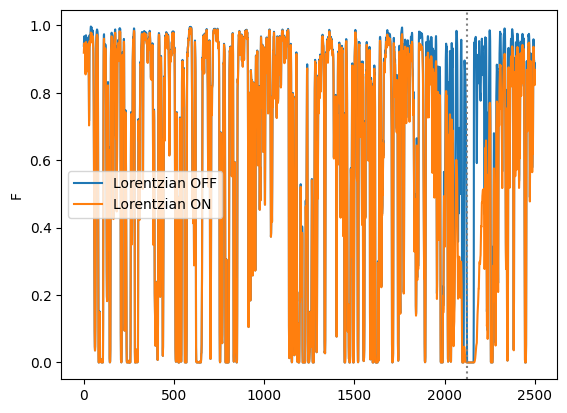

In [8]:
# plot the skewer with and without self-shielding
plt.plot(np.exp(-tau_off[plot_isk]),label='Lorentzian OFF')
plt.plot(np.exp(-tau_on[plot_isk]),label='Lorentzian ON')
plt.axvline(x=idla,ls=':',color='gray')
plt.ylabel('F')
plt.legend();

### Isolate the HCD absorption (for simplicity, use only a fraction of the data)

In [9]:
keep_sk=10000
tau_on=tau_on[:keep_sk]
tau_off=tau_off[:keep_sk]

In [10]:
print(np.min(tau_on), np.max(tau_on), np.mean(tau_on), np.mean(np.exp(-tau_on)))

0.00030190026154741645 1623694208.0 31711.937902711867 0.6047058112691976


In [11]:
print(np.min(tau_off), np.max(tau_off), np.mean(tau_off), np.mean(np.exp(-tau_off)))

3.516956348903477e-05 1623856128.0 31711.947100753918 0.6306333461206637


In [12]:
tau_max = np.fmax(tau_on, tau_off)
print(np.min(tau_max), np.max(tau_max), np.mean(tau_max), np.mean(np.exp(-tau_max)))

0.0005647620419040322 1623856128.0 31715.830151796134 0.6047033291374256


In [13]:
new_on=np.copy(tau_on[plot_isk])
new_off=np.copy(tau_off[plot_isk])
new_max=np.copy(tau_max[plot_isk])
new_hcd=new_max-new_off

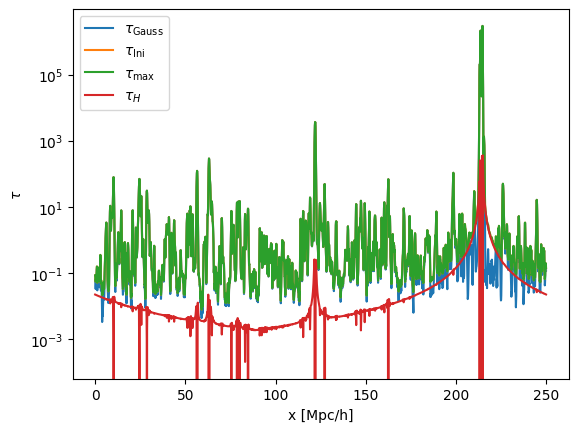

In [14]:
# plot the skewer with and without self-shielding
plt.semilogy(x, new_off,label=r'$\tau_{\rm Gauss}$')
plt.semilogy(x, new_on,label=r'$\tau_{\rm Ini}$')
plt.semilogy(x, new_max,label=r'$\tau_{\rm max}$')
plt.semilogy(x, new_hcd,label=r'$\tau_H$')
plt.ylabel(r'$\tau$')
plt.xlabel('x [Mpc/h]')
plt.legend()
plt.savefig('tau_max.png')

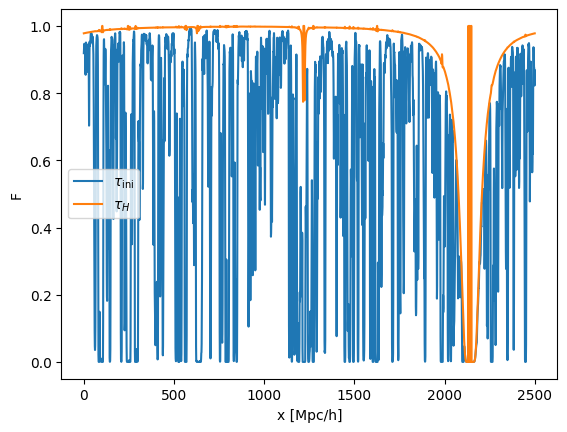

In [15]:
# plot the skewer with and without self-shielding
#plt.plot(np.exp(-new_off),label=r'$\tau_{\rm Gauss}$')
plt.plot(np.exp(-new_on),label=r'$\tau_{\rm ini}$')
plt.plot(np.exp(-new_hcd),label=r'$\tau_H$')
plt.ylabel('F')
plt.legend()
plt.xlabel('x [Mpc/h]')
plt.savefig('F_max.png')

In [16]:
# play with filtering of tau
tau_modes = np.fft.rfft(new_hcd)
k = np.fft.rfftfreq(Np)*2*np.pi/dz_hMpc

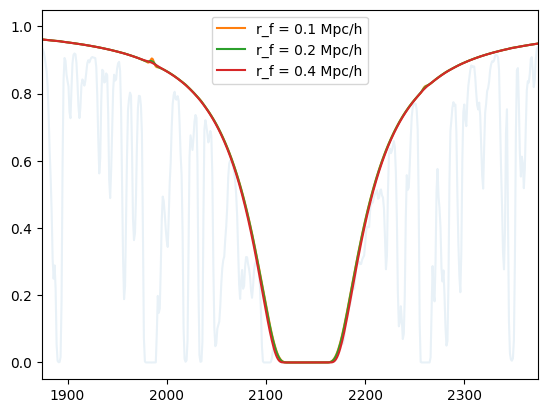

In [17]:
plt.plot(np.exp(-new_on), alpha=0.1)
for r_fil in [0.1, 0.2, 0.4]:
    tau_fil = np.fft.irfft(tau_modes * np.exp(-(r_fil*k)**2))
    plt.plot(np.exp(-tau_fil),label='r_f = {} Mpc/h'.format(r_fil)) 
plt.xlim(idla-250,idla+250)
plt.legend()

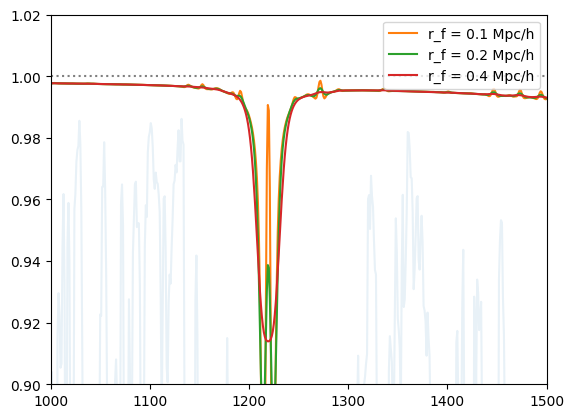

In [18]:
plt.plot(np.exp(-new_on), alpha=0.1)
for r_fil in [0.1, 0.2, 0.4]:
    tau_fil = np.fft.irfft(tau_modes * np.exp(-(r_fil*k)**2))
    plt.plot(np.exp(-tau_fil),label='r_f = {} Mpc/h'.format(r_fil)) 
plt.axhline(y=1, ls=':', color='gray')
plt.xlim(1000,1500)
plt.ylim(0.9,1.02)
plt.legend()

In [19]:
def plot_filtered_dla(log_NHI_min=19,log_NHI_max=20, r_hMpc=0.3):
    # identify line-of-sight with interesting DLA
    plot_mask = ((np.log10(max_colden) > log_NHI_min) & (np.log10(max_colden) < log_NHI_max)).flatten()
    plot_isk=np.where(plot_mask)[0][0]
    print(plot_isk, np.log10(max_colden.flatten()[plot_isk]))

    # extract HCD contamination
    plot_on=np.copy(tau_on[plot_isk])
    print(np.mean(plot_on), np.mean(np.exp(-plot_on)))
    plot_off=np.copy(tau_off[plot_isk])
    print(np.mean(plot_off), np.mean(np.exp(-plot_off)))
    # the HCD optical depth can not be negative
    tau_max = np.fmax(plot_on, plot_off)
    print(np.mean(tau_max), np.mean(np.exp(-tau_max)))
    tau_hcd=tau_max-plot_off
    print(np.mean(tau_hcd), np.mean(np.exp(-tau_hcd)))
    
    # filter tau
    tau_modes = np.fft.rfft(tau_hcd)
    k = np.fft.rfftfreq(Np)*2*np.pi/dz_hMpc
    tau_fil = np.fft.irfft(tau_modes * np.exp(-(r_hMpc*k)**2))
    print(np.mean(tau_fil), np.mean(np.exp(-tau_fil)))

    #plt.plot(np.exp(-plot_on), alpha=0.4, label='Total')
    #plt.plot(np.exp(-plot_off), alpha=0.4, label='Lya')
    plt.plot(np.exp(-tau_hcd),label='original')
    plt.plot(np.exp(-tau_fil),ls=':',label='r_f = {} Mpc/h'.format(r_hMpc)) 
    #plt.xlim(idla-250,idla+250)
    plt.legend()

4 19.978807657367405
6320.371404796102 0.5854088800745196
6320.3732814043115 0.6250810459483851
6321.789195082357 0.5854088799903979
1.415913678046316 0.927161669408761
1.415913678046316 0.9239469534771743


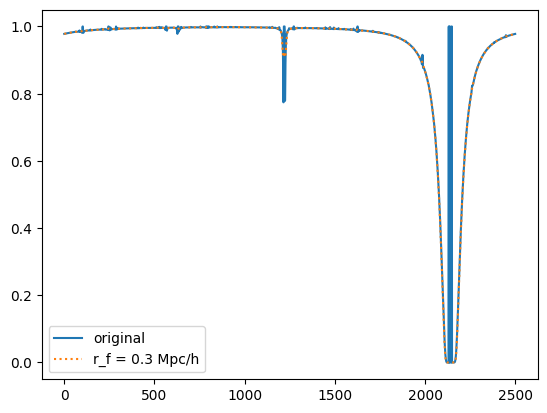

In [20]:
plot_filtered_dla(log_NHI_min=19,log_NHI_max=20, r_hMpc=0.3)

6 21.380728183451875
121093.09367168562 0.42669219872308467
121093.12755845342 0.6037686416331272
121110.939143878 0.42669219872308467
17.811585424643102 0.7035037972657661
17.811585424643102 0.7006668652703284


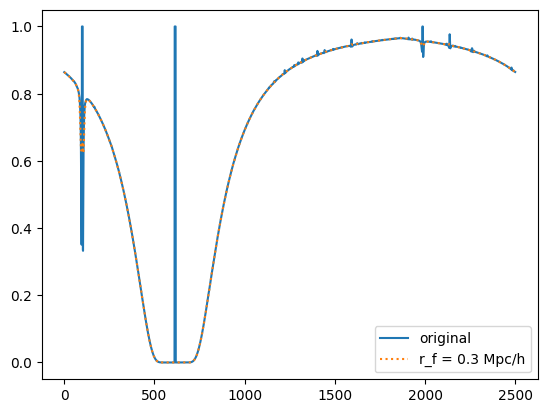

In [21]:
plot_filtered_dla(log_NHI_min=21,log_NHI_max=21.5, r_hMpc=0.3)

16 17.553386336184555
40.00835771866907 0.6095052893625401
40.00838674337808 0.6105578775586714
40.015252473502045 0.6095027922235084
0.006865730123966933 0.9942774199536961
0.0068657301239669335 0.9937707091124803


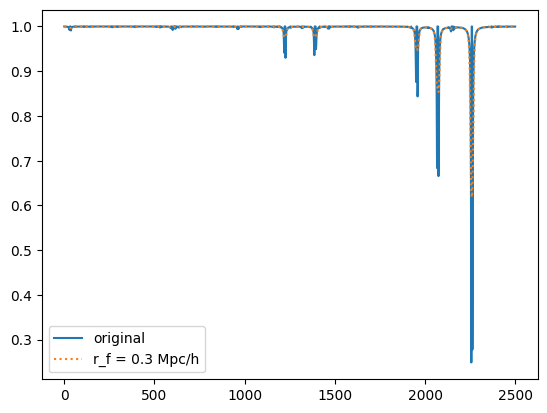

In [22]:
plot_filtered_dla(log_NHI_min=17.5,log_NHI_max=18.0, r_hMpc=0.3)

### Recommended path forward

In [23]:
# this will be used as the total optical depth
tau_max = np.fmax(tau_on, tau_off)

In [24]:
# this will be used as a first guess of HCD contamination
tau_hcd = tau_max - tau_off
# that will then be smoothed
tau_modes = np.fft.rfft(tau_hcd)
k = np.fft.rfftfreq(Np)*2*np.pi/dz_hMpc
r_hMpc=0.3
tau_hcd = np.fft.irfft(tau_modes * np.exp(-(r_hMpc*k)**2))

In [25]:
# this will be used as the Lya optical depth 
tau_lya = tau_off
# this will be the total optical depth
tau_tot = tau_lya + tau_hcd

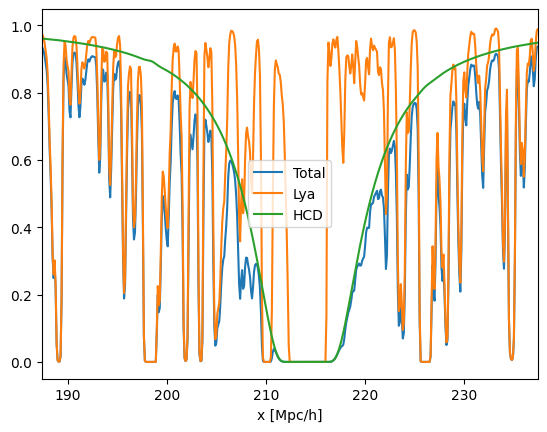

In [26]:
x = dz_hMpc * np.arange(Np)
plt.plot(x,np.exp(-tau_tot[plot_isk]), label='Total')
plt.plot(x,np.exp(-tau_lya[plot_isk]), label='Lya')
plt.plot(x,np.exp(-tau_hcd[plot_isk]), label='HCD')
plt.xlim(dz_hMpc*(idla-250),dz_hMpc*(idla+250))
plt.xlabel('x [Mpc/h]')
plt.legend()
plt.savefig('total_lya_hcd.png')

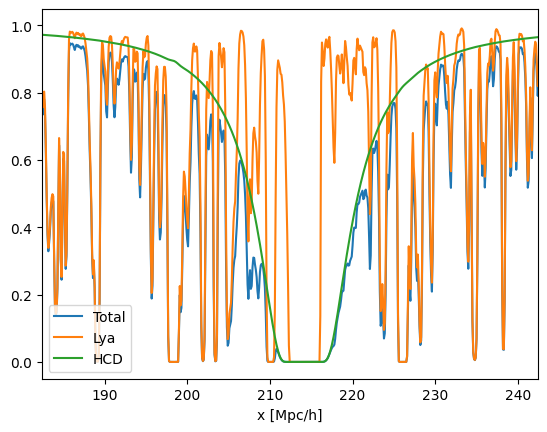

In [27]:
x = dz_hMpc * np.arange(Np)
plt.plot(x,np.exp(-tau_tot[plot_isk]), label='Total')
plt.plot(x,np.exp(-tau_lya[plot_isk]), label='Lya')
plt.plot(x,np.exp(-tau_hcd[plot_isk]), label='HCD')
plt.xlim(dz_hMpc*(idla-300),dz_hMpc*(idla+300))
plt.xlabel('x [Mpc/h]')
plt.legend()
plt.savefig('total_lya_hcd.png')